In [1]:
import cv2
import os
import numpy as np
import imutils
from matplotlib import pyplot as plt


from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

In [3]:
def SIFT(inputname):
    r_img = []
    r_img1 = []
    r_img2 = []
    r_img3 = []
    all_img1 = []
    read_directory(inputname)
    #use: len(array_of_img) for looping the image, array_of_img[0],
    #array_of_img[1],array_of_img[2],...for processing each image
    #Start SIFT here
    #print(inputname)
    #all_img.remove(None)
    #print(len(all_img))
    for i in range(0,len(all_img)):
        if str(all_img[i]) != str('None'):
            all_img1.append(all_img[i])
        else:
            continue
    #print(len(all_img1))
    #all_img1 = list(filter(None, all_img)) 

    
    half1 = int(round((len(all_img1))/4))
    half2 = int(round((len(all_img1))*2/4))
    half3 = int(round((len(all_img1))*3/4))

    half1 = int(round((len(all_img1))/4))
    half2 = int(round((len(all_img1))*2/4))
    half3 = int(round((len(all_img1))*3/4))
    
    #print(half1,half2,half3)
    

    for i in range(0,half1):
        #print(len(r_img))
        if len(r_img) < 2:
            r_img.append(all_img1[i])
            continue
        elif len(r_img) >= 2:
            r_img.append(all_img1[i])
            r = stitch(r_img[-2:],time = 2.1)
            r_img.append(r)
    for i in range(half1,half2):
        if len(r_img1) < 2:
            r_img1.append(all_img1[i])
            continue
        elif len(r_img1) >= 2:
            r_img1.append(all_img1[i])
            r = stitch(r_img1[-2:],time = 2.1)
            r_img1.append(r)
    for i in range(half2,half3):
        if len(r_img2) < 2:
            r_img2.append(all_img1[i])
            continue
        elif len(r_img2) >= 2:
            r_img2.append(all_img1[i])
            r = stitch(r_img2[-2:],time = 2.1)
            r_img2.append(r)
    for i in range(half3,len(all_img1)):
        if len(r_img3) < 2:
            r_img3.append(all_img1[i])
            continue
        elif len(r_img3) >= 2:
            r_img3.append(all_img1[i])
            r = stitch(r_img3[-2:],time = 2.1)
            r_img3.append(r)
    #plt.imshow(r_img3[-1])
    result1 = [r_img[-1],r_img1[-1]]
    result2 = [r_img2[-1],r_img3[-1]]
    r1 = stitch(result1,time = 2.1)
    r2 = stitch(result2,time = 2.1)
    result3 = [r1,r2]
    r3 = stitch(result3,time = 2.1)
    
      
    imageoutput = r3
    return imageoutput

In [4]:
def detectAndDescribe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    descriptor = cv2.xfeatures2d.SIFT_create() 
    (keypoints, desc) = descriptor.detectAndCompute(image, None) 

    keypoints= np.float32([kp.pt for kp in keypoints])


    return (keypoints, desc)

In [5]:
def match_descriptors(descA,descB,ratio):

    matcher = cv2.DescriptorMatcher_create("BruteForce") 
    rawMatches = matcher.knnMatch(descA, descB, 2) 
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    return matches

In [6]:
def RANSAC(keypoints1,keypoints2,matches,thresh):
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([keypoints1[i] for (_, i) in matches])
        ptsB = np.float32([keypoints2[i] for (i, _) in matches])

        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,thresh) 

        return H,status
    return None

In [7]:
def get_column_index(img,height,num=50):

    t = img.copy()
    th,ma = cv2.threshold(t,0,255,cv2.THRESH_BINARY)
    ma = cv2.cvtColor(ma,cv2.COLOR_BGR2GRAY)

    last_index_top = 0
    last_index_bot = 0
    last_index = 0
    for i in range(ma.shape[1]-1,-1,-1):
        if ma[0][i] != 0:
            last_index_top=i
            break
    for i in range(ma.shape[1]-1,-1,-1):
        if ma[height-1][i] != 0:
            last_index_bot=i
            break

    if last_index_bot > last_index_top:
        last_index = last_index_bot
    else:
        last_index = last_index_top

    return last_index-num ##

In [8]:
def merge_from_image_warp(warp1,warp2,height,width):

    mask = cv2.bitwise_and(warp1,warp2)

    last_index = get_column_index(mask,height)
    for i in range(height):
        for j in range(width):
            if j < last_index:
                warp2[i, j] = warp1[i, j]

    return warp2

In [9]:
def remove_black(img):

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    last_index = 0
    for i in range(gray.shape[1]-1,-1,-1):
        if gray[int(gray.shape[0]/2)][i] != 0:
            last_index=i
            break

    result = img[:,0:last_index]

    return result


In [10]:
def stitch(images,ratio=0.8,reprojThresh=4.0,time=2.0):

    ## Set default size of panorama picture ( sum( width of images ) x height of first image
    pano_height = images[0].shape[0]
    pano_width = 0
    for i in images:
        #print(i)
        if i.any() == None:
            continue
        else:
            pano_width = pano_width + i.shape[1]

    keypoints = []
    descriptors = []
    matches = []
    ## Return keypoints and descriptors
    for i in images:
        kp ,desc = detectAndDescribe(i)
        #kp ,desc = SIFT1(i)
        keypoints.append(kp) ## DoG
        descriptors.append(desc)  ## SIFT

    for i in range(len(images)-1):
        m = match_descriptors(descriptors[i],descriptors[i+1],ratio) ## Nối match
        matches.append(m)

    Homo = []
    for i in range(len(images)-1):

        h , status = RANSAC(keypoints[i],keypoints[i+1],matches[i],reprojThresh)
        Homo.append(h)

    ## Calculate Referernce Matrix
    refernce_h = [Homo[0]]
    for i in range(1,len(Homo)):
        h_to_iv = np.dot(Homo[i],refernce_h[i-1])
        refernce_h.append(h_to_iv)

    ## Warp Images
    warp_img = []
    wm = cv2.warpPerspective(images[0],np.eye(3),(pano_width, pano_height))
    warp_img.append(wm)
    for i in range(1,len(images)):
        wm = cv2.warpPerspective(images[i],(np.linalg.inv(refernce_h[i-1])),(pano_width,pano_height))
        warp_img.append(wm)

    ## Merge Each Image
    result = None
    for i in range(len(warp_img)-1):
        result = merge_from_image_warp(warp_img[i],warp_img[i+1],pano_height ,pano_width)
    #result = imutils.resize(result, width=800)
    result = remove_black(result)

    return result

In [11]:

logger = logging.getLogger(__name__)
float_tolerance = 1e-7


def SIFT1(image):
    image = image.astype('float32')
    sigma=1.6
    num_intervals=3 
    assumed_blur=0.5 
    image_border_width=5
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)

    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors


def generateBaseImage(image, sigma, assumed_blur):
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)     # input image size double
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    return int(round(log(min(image_shape)) / log(2) - 1))                    

def generateGaussianKernels(sigma, num_intervals):
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3                                # why +3? + 2 for one blur step before the first image in the layer and another blur step after the last image in the layer.
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)                          # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur

        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)

            #plt.imshow(image)
            #plt.show()

        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)

    return array(gaussian_images)

def generateDoGImages(gaussian_images):
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers

            #plt.imshow(subtract(second_image, first_image))
            #plt.show()

        dog_images.append(dog_images_in_octave)
    return array(dog_images)


def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []
    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    #print(center_pixel_value)
    #print(threshold)
    if abs(center_pixel_value).all() > 0.5:
        if center_pixel_value.all() > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value.all() < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations


def compareKeypoints(keypoint1, keypoint2):
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints


def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    logger.debug('Generating descriptors...')
    descriptors = []
    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

In [12]:
all_img = []
def read_directory(dirname):
    all_img.clear()
    #all_img = []
    filenumber = len([name for name in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread('./' + dirname + "/" + str(i) + ".jpg")
        #plt.imshow(img)
        #img = cv.resize
        #img = cv2.resize(img, (int(img.shape[1]/10),int(img.shape[0]/10)))
        all_img.append(img)

parrington
NCTU


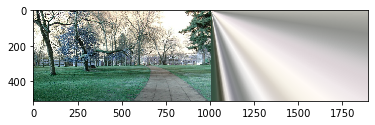

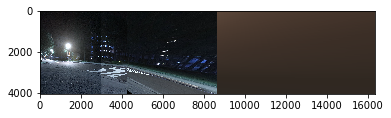

In [13]:
f = open('testfile.txt','r')
dirname = str(f.readline()).strip()
#print(dirname)
while(dirname):
    print(dirname)
    imageout = SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg',imageout)
    dirname = str(f.readline()).strip()

In [14]:
def Visualize_keypoints(img,keypoints):
    print(len(keypoints))
    implot = plt.imshow(img,cmap="gray")
    #for point in keypoints:
    x=[]
    y=[]
    for pt in keypoints:
        x.append(pt.pt[0])
        y.append(pt.pt[1])
    plt.plot(x,y,'y+')
    plt.show()

In [15]:
#Testing SIFT
image = cv2.imread("./NCTU/1.jpg")
image = image.astype('float32')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sigma=1.6
num_intervals=3 
assumed_blur=0.5 
image_border_width=5
base_image = generateBaseImage(image, sigma, assumed_blur)
num_octaves = computeNumberOfOctaves(base_image.shape)

gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
dog_images = generateDoGImages(gaussian_images)
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
print(len(keypoints))
Visualize_keypoints(base_image,keypoints)
keypoints = removeDuplicateKeypoints(keypoints)
Visualize_keypoints(base_image,keypoints)
keypoints = convertKeypointsToInputImageSize(keypoints)
descriptors = generateDescriptors(keypoints, gaussian_images)

/Users/weichilee/opt/anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/weichilee/opt/anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.set_figheight(100)
fig.set_figwidth(50)
for idx,pic in enumerate(gaussian_images[1]):
    fig.add_subplot(9, 5, idx+1)
    plt.imshow(pic,cmap='gray')
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(100)
fig.set_figwidth(50)
for idx,pic in enumerate(dog_images[1]):
    fig.add_subplot(9, 5, idx+1)
    plt.imshow(pic,cmap='gray')
plt.show()
np.set_printoptions(threshold=np.inf)